In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys

from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD


sys.path.append("../")
from src.load_config import LoadConfig
from src.utils import (
    preprocess_mat_data,
    short_term_fourier_transform_stft,
    plot_stft_results,
)

APPCFG = LoadConfig()

#  DATA PATHS
mat_px_ra = "../data/Datos_Matlab/Datos_210509-094222_PX_RA.mat"

[2024-10-16T09:52:11+0000] [INFO] [286] [utils] Number of samples: 271300
[2024-10-16T09:52:11+0000] [INFO] [290] [utils] Total time: [36072.   36072.01 36072.02 ... 38784.97 38784.98 38784.99]
[2024-10-16T09:52:11+0000] [INFO] [296] [utils] Window samples: 25
[2024-10-16T09:52:11+0000] [INFO] [304] [utils] Overlap: 23


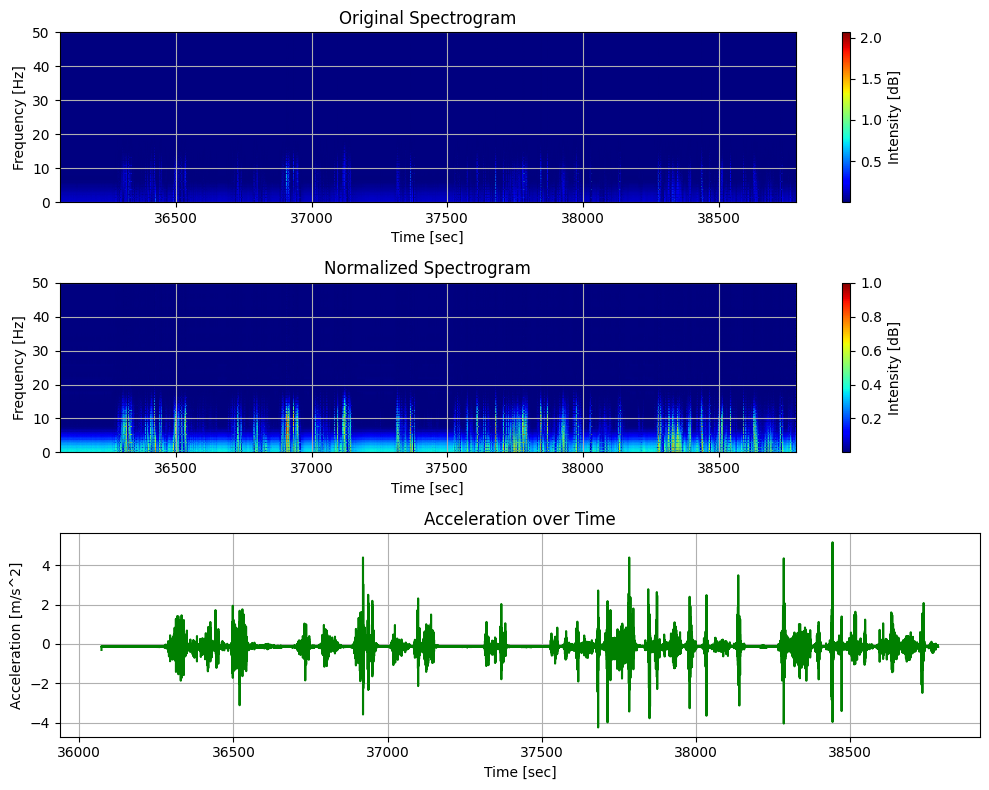

In [2]:
(
    data_f20_10_px_ra_mat,
    signal_acc_mat,
    time_column_mat,
    df_mat,
) = preprocess_mat_data(
    data_path=mat_px_ra,
    acel_to_process=APPCFG.acceleration_to_analyze,
    time_col_name="timestamp_s",
)

(
    frequencies_acc,
    times_acc,
    magnitude_spectrogram_acc,
    X_prime_acc,
    total_time_acc,
) = short_term_fourier_transform_stft(
    signal=signal_acc_mat,
    sampling_frequency_stft=APPCFG.sampling_frequency_stft_prepared,
    window_length=APPCFG.window_length,
    overlap=APPCFG.overlap,
    gamma=APPCFG.gamma,
    time_column=time_column_mat,
    nfft=APPCFG.nfft_prepared,
)

plot_stft_results(
    frequencies_acc,
    times_acc,
    magnitude_spectrogram_acc,
    X_prime_acc,
    total_time_acc,
    signal_acc_mat,
)




In [3]:
print(f"Shape of STFT time array: {times_acc.shape}")
print(f"Full time range: {times_acc.min()} to {times_acc.max()}")
print(f"Number of time points: {len(times_acc)}")
print(f"Time range of original signal: {time_column_mat.min()} to {time_column_mat.max()}")

Shape of STFT time array: (135651,)
Full time range: 36072.0 to 38785.0
Number of time points: 135651
Time range of original signal: 36072.0 to 38784.99


In [4]:
# Calculate num_freq_bins and num_time_bins
num_freq_bins, num_time_bins = magnitude_spectrogram_acc.shape
print("num_freq_bins:", num_freq_bins)
print("num_time_bins:", num_time_bins)

# Flatten the spectrogram for PCA and clustering
spectrogram_flattened = magnitude_spectrogram_acc.flatten().reshape(
    num_time_bins, num_freq_bins
)
print("Spectrogram shape:", magnitude_spectrogram_acc.shape)
print("Flattened spectrogram shape:", spectrogram_flattened.shape)

num_freq_bins: 65
num_time_bins: 135651
Spectrogram shape: (65, 135651)
Flattened spectrogram shape: (135651, 65)


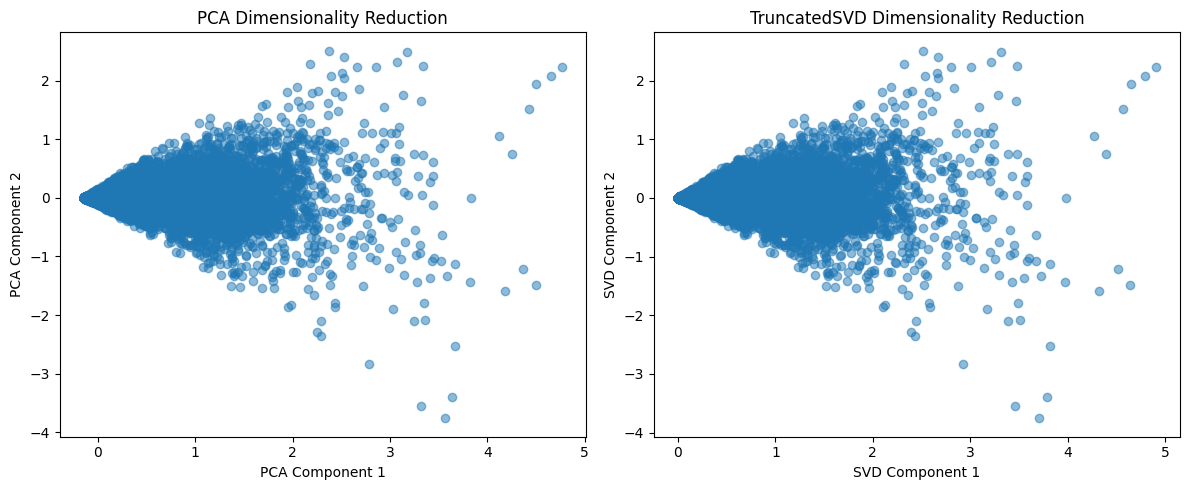

In [5]:


# Option 1: PCA
pca = PCA(n_components=2, random_state=42)
reduced_features_pca = pca.fit_transform(spectrogram_flattened)

# Option 2: TruncatedSVD (faster for very large datasets)
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_features_svd = svd.fit_transform(spectrogram_flattened)

# Visualize the reduced features
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(reduced_features_pca[:, 0], reduced_features_pca[:, 1], alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Dimensionality Reduction")

plt.subplot(122)
plt.scatter(reduced_features_svd[:, 0], reduced_features_svd[:, 1], alpha=0.5)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("TruncatedSVD Dimensionality Reduction")

plt.tight_layout()
plt.show()

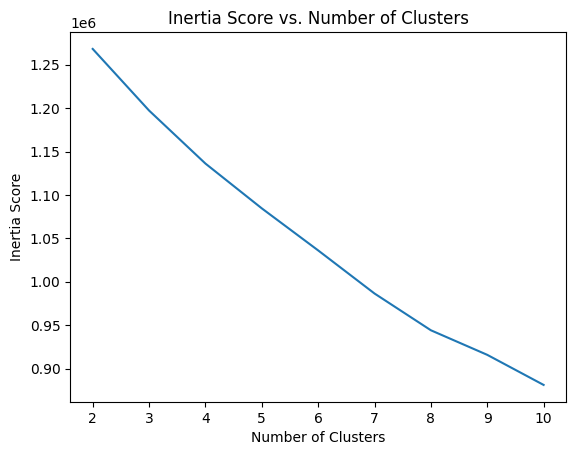

Best number of clusters: 9


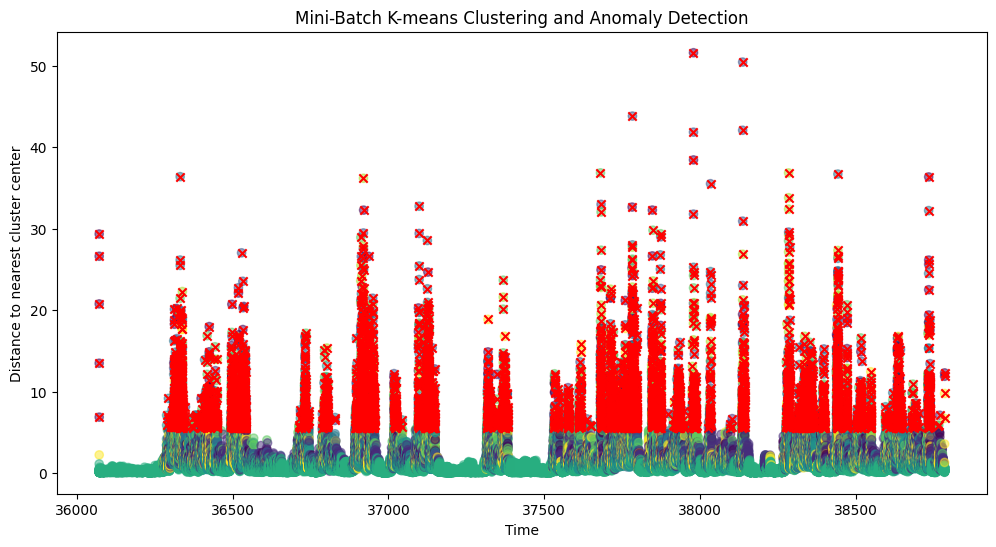

Anomalies saved to 'anomalies_mbkmeans_revised.csv'
Anomaly time range: 36072.0 to 38785.0


In [7]:
# Instead of flattening, let's use the original spectrogram shape
spectrogram_2d = magnitude_spectrogram_acc.T  # Transpose to have time on the first axis

# Apply PCA or TruncatedSVD
pca = PCA(n_components=10, random_state=42)  # Increase components to capture more variance
reduced_features = pca.fit_transform(spectrogram_2d)

# Normalize the features
scaler = StandardScaler()
reduced_features_scaled = scaler.fit_transform(reduced_features)


#!#############################

# Define a range of values for the number of clusters
num_clusters = list(range(2, 11))

# Calculate the inertia scores for each number of clusters
inertia_scores = []
for n_clusters in num_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(reduced_features_scaled)
    inertia = kmeans.inertia_
    inertia_scores.append(inertia)

# Plot the inertia scores
plt.plot(num_clusters, inertia_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.title("Inertia Score vs. Number of Clusters")
plt.show()

# Calculate the differences (first derivative) and the second derivative
first_derivative = np.diff(inertia_scores)
second_derivative = np.diff(first_derivative)

# The elbow point is where the second derivative is maximized (biggest change)
best_num_clusters = num_clusters[
    np.argmax(second_derivative) + 2
]  # +2 to adjust for the diff index
print("Best number of clusters:", best_num_clusters)

#!#############################






# Apply Mini-Batch K-means
n_clusters = best_num_clusters
mbkmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = mbkmeans.fit_predict(reduced_features_scaled)

# Identify potential anomalies
distances = mbkmeans.transform(reduced_features_scaled).min(axis=1)
threshold = np.percentile(distances, 95)  # Adjust percentile as needed
anomalies = distances > threshold

# Visualize results
plt.figure(figsize=(12, 6))
plt.scatter(times_acc, distances, c=cluster_labels, alpha=0.5)
plt.scatter(times_acc[anomalies], distances[anomalies], c='red', marker='x')
plt.xlabel("Time")
plt.ylabel("Distance to nearest cluster center")
plt.title("Mini-Batch K-means Clustering and Anomaly Detection")
plt.show()

# Save anomalies
anomaly_indices = np.where(anomalies)[0]
anomaly_times = times_acc[anomaly_indices]

anomalies_df = pd.DataFrame({
    'Anomaly_Index': anomaly_indices,
    'Anomaly_Time': anomaly_times,
})
anomalies_df.to_csv('anomalies_mbkmeans_revised.csv', index=False)
print(f"Anomalies saved to 'anomalies_mbkmeans_revised.csv'")
print(f"Anomaly time range: {anomaly_times.min()} to {anomaly_times.max()}")

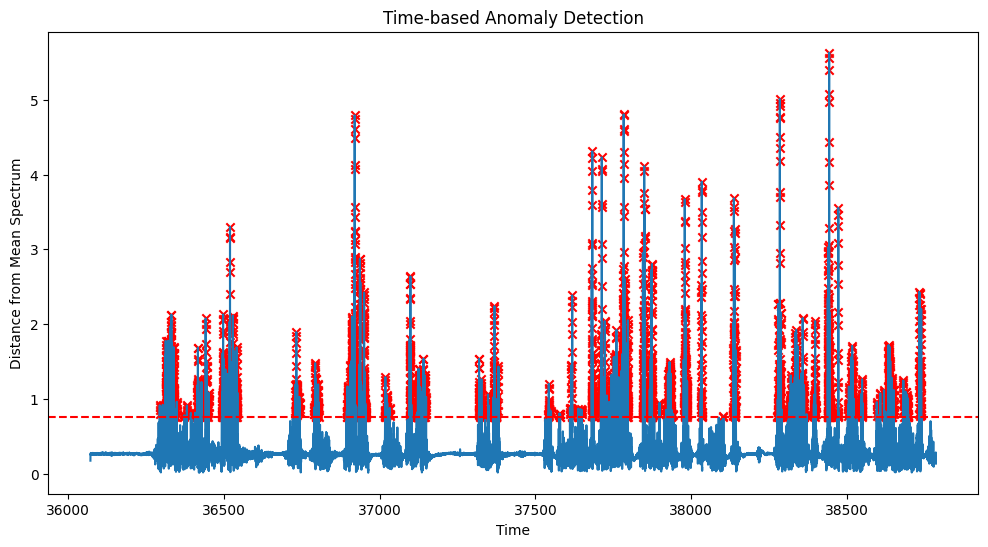

Time-based anomalies saved to 'time_based_anomalies_revised.csv'
Time-based anomaly range: 36294.4 to 38738.12


In [8]:
# Calculate the mean spectrum for each time point
mean_spectrum = np.mean(magnitude_spectrogram_acc, axis=0)

# Calculate the distance of each spectrum from the mean
distances_from_mean = np.linalg.norm(magnitude_spectrogram_acc - mean_spectrum, axis=0)

# Identify anomalies based on distance from mean
threshold = np.mean(distances_from_mean) + 2 * np.std(distances_from_mean)
time_anomalies = distances_from_mean > threshold

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(times_acc, distances_from_mean)
plt.scatter(times_acc[time_anomalies], distances_from_mean[time_anomalies], c='red', marker='x')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Distance from Mean Spectrum")
plt.title("Time-based Anomaly Detection")
plt.show()

# Save time-based anomalies
time_anomaly_indices = np.where(time_anomalies)[0]
time_anomaly_times = times_acc[time_anomaly_indices]

time_anomalies_df = pd.DataFrame({
    'Anomaly_Index': time_anomaly_indices,
    'Anomaly_Time': time_anomaly_times
})
time_anomalies_df.to_csv('time_based_anomalies_revised.csv', index=False)
print(f"Time-based anomalies saved to 'time_based_anomalies_revised.csv'")
print(f"Time-based anomaly range: {time_anomaly_times.min()} to {time_anomaly_times.max()}")

In [12]:
print(f"Total number of data points: {len(times_acc)}")
print(f"Mini-Batch K-means anomalies: {len(anomaly_indices)}, Percentage: {np.round(len(anomaly_indices)/len(times_acc)*100, 2)}%")
print(f"Mini-Batch K-means time range: {anomaly_times.min()} to {anomaly_times.max()}")
print(f"Time-based anomalies: {len(time_anomaly_indices)}, Percentage: {np.round(len(time_anomaly_indices)/len(times_acc)*100, 2)}%")
print(f"Time-based anomaly range: {time_anomaly_times.min()} to {time_anomaly_times.max()}")

Total number of data points: 135651
Mini-Batch K-means anomalies: 6783, Percentage: 5.0%
Mini-Batch K-means time range: 36072.0 to 38785.0
Time-based anomalies: 4738, Percentage: 3.49%
Time-based anomaly range: 36294.4 to 38738.12
